## Import Libraries

In [1]:
import pandas as pd
import json
import numpy as np
from collections import Counter
import matplotlib.pyplot as plt
%matplotlib inline

## Load Data

In [2]:
# filenames
firebase_data = 'data/data.json'
query_subset_filename = 'data/queries.dev.small.tsv'
qrels_filename = 'data/qrels.dev.small.tsv'
bm25_filename = 'data/run_development_top100.tsv'
assessor_info = 'data/assessor_info.tsv'

In [3]:
with open(firebase_data, 'r') as infile:
    data = json.load(infile)
query_ids = list(data.keys())

In [4]:
query_subset = pd.read_csv(query_subset_filename,delimiter='\t',encoding='utf-8', header=None)
query_subset.columns = ['query_id', 'query']

In [5]:
bm25_df = pd.read_csv(bm25_filename,delimiter='\t',encoding='utf-8',header=None)
bm25_df.columns = ['query_id', 'passage_id','bm25_rank']

In [6]:
qrels_df = pd.read_csv(qrels_filename,delimiter='\t',encoding='utf-8',header=None)
qrels_df.columns = ['query_id','label1','passage_id','label2']

In [7]:
assessor_df = pd.read_csv(assessor_info,delimiter='\t',encoding='utf-8',header=None)
assessor_df.columns = ["user_id","email","consent","contact","english","progress","assessed_queries"]

In [29]:
experiment_query_ids = []
with open("output/experiment_queries.txt", "r") as infile:
    for line in infile:
        experiment_query_ids.append(line.rstrip())

## Create DataFrames per Query

In [30]:
def create_labels(nr_assessors):
    labels = ["query_id","passageid","msmarco"]
    for i in range(nr_assessors):
        labels = labels + ['user%s_id'%(i+1),'user%s_label'%(i+1)]
    return labels

In [31]:
dataframe_data = {}
label_data = {}
assessor_data = {}
for query_id in experiment_query_ids:
    query_data_lists = []
    query_data = data[query_id]
    nr_assessors = 0
    for i, passage_id in enumerate(query_data.keys()):
        dataFrameRow2be = [query_id, passage_id] + query_data[passage_id]
        query_data_lists.append(dataFrameRow2be)
        if i == 0:
            nr_assessors = int((len(query_data[passage_id])-1)/2)
    dataframe_data[query_id] = query_data_lists
    label_data[query_id] = create_labels(nr_assessors)
    assessor_data[query_id] = nr_assessors

In [32]:
dataframes = {}
for query_id in experiment_query_ids:
    df = pd.DataFrame(dataframe_data[query_id],columns=label_data[query_id])
    dataframes[query_id] = df

## Fix Missing Data

In [33]:
del dataframes['993153']['user2_label']
del dataframes['993153']['user2_id']

In [34]:
assessor_data['993153'] = 6

In [35]:
nr_assessors = assessor_data['993153']
user_column_names = []
for i in range(nr_assessors):
    user_column_names = user_column_names + ["user%s_id"%(i+1), "user%s_label"%(i+1)]
dataframes['993153'].columns = ['query_id','passageid','msmarco'] + user_column_names

## Experiment Dataset Stats

1. What is the number of assessors per query?

In [36]:
assessor_count_list = []
for query_id in experiment_query_ids:
    nr_assessors = assessor_data[query_id]
    assessor_count_list.append(nr_assessors)

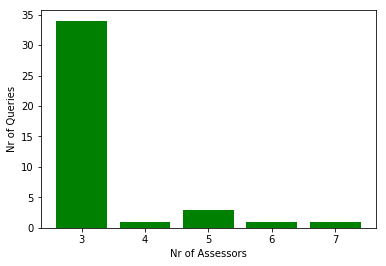

In [37]:
assessor_counts = Counter(assessor_count_list)
plt.bar(list(assessor_counts.keys()), assessor_counts.values(), color='g')
plt.xlabel("Nr of Assessors")
plt.ylabel("Nr of Queries")
plt.show()

In [28]:
assessor_counts

Counter({3: 34, 4: 1, 5: 3, 6: 1, 7: 1})

2. How many terms does each query contain?

In [38]:
experiment_query_subset = query_subset[query_subset['query_id'].isin(experiment_query_ids)].copy()

In [39]:
experiment_query_subset.to_csv("output/experiment_query_subset.tsv",sep="\t", header=False,index=False)

In [46]:
experiment_query_texts = experiment_query_subset['query'].values.tolist()
with open("output/experiment_query_texts.txt","w") as outfile:
    for query_text in experiment_query_texts:
        outfile.write("%s\n"%(query_text))

In [40]:
query_texts = experiment_query_subset['query'].values.tolist()

In [41]:
query_lengths = []
for query_text in query_texts:
    query_lengths.append(len(query_text.split()))
query_lengths_counter = Counter(query_lengths)

In [42]:
query_lengths_counter

Counter({3: 3,
         4: 1,
         5: 9,
         6: 11,
         7: 6,
         8: 4,
         9: 1,
         10: 1,
         11: 2,
         12: 1,
         15: 1})

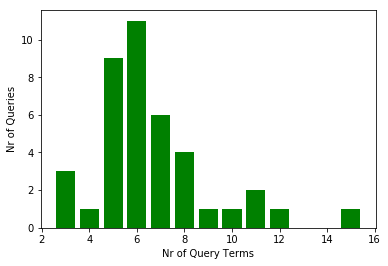

In [43]:
plt.bar(list(query_lengths_counter.keys()), query_lengths_counter.values(), color='g')
plt.xlabel("Nr of Query Terms")
plt.ylabel("Nr of Queries")
plt.show()

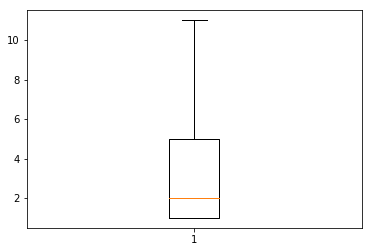

In [44]:
plt.boxplot(list(query_lengths_counter.values()))
plt.show()

In [45]:
np.median(list(query_lengths_counter.values()))

2.0

3. What type of queries does the dataset contain?

In [48]:
experiment_answer_types = {}
counter_answer_types = 0
counter_no_answer_types = 0
with open("output/experiment_answer_types.txt", "r") as infile:
    for line in infile:
        if("\t" in line.rstrip()):
            counter_answer_types += 1
            [query_text,answer_type] = line.rstrip().split("\t")
            experiment_answer_types[query_text] = answer_type.split(":")[0]
        else:
            if not line.rstrip() == "":
                counter_no_answer_types += 1
                experiment_answer_types[line.rstrip()] = ""

In [49]:
print("There are %s queries for which no answer type could be classified."%(counter_no_answer_types))

There are 19 queries for which no answer type could be classified.


In [50]:
with open("output/manual_answer_types.txt", "r", encoding='utf-8') as infile:
    for line in infile:
        [query_text,answer_type] = line.rstrip().split("\t")
        if query_text in experiment_answer_types.keys():
            experiment_answer_types[query_text] = answer_type

In [51]:
for query_text, answer_type in experiment_answer_types.items():
    if answer_type == "":
        print(query_text)

In [52]:
answer_types = list(experiment_answer_types.values())
answer_types_counts = Counter(answer_types)

In [53]:
answer_type_count_tuples = sorted(answer_types_counts.items(), key=lambda item: item[1],reverse=True)
answer_types_sorted_on_count = [k for k, v in answer_type_count_tuples]
answer_type_counts_sorted_on_count = [v for k, v in answer_type_count_tuples]

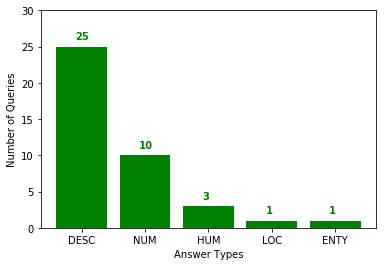

In [54]:
fig, ax = plt.subplots() 
ax.bar(answer_types_sorted_on_count, answer_type_counts_sorted_on_count, color='g')
for i, v in enumerate(answer_type_counts_sorted_on_count):
    ax.text(i - 0.1, v + 1 , str(v), color='g', fontweight='bold')
ax.set_ylim([0,30])
plt.xlabel("Answer Types")
plt.ylabel("Number of Queries")
plt.show()

In [55]:
answer_types_counts

Counter({'DESC': 25, 'ENTY': 1, 'HUM': 3, 'LOC': 1, 'NUM': 10})

4. How many queries are assessed by low English level assessors?

In [56]:
low_level_assessors_df = assessor_df[assessor_df['english'] < 7]
low_english_level_users = list(np.unique(low_level_assessors_df['user_id'].values.tolist()))
counter = 0
for query_id in experiment_query_ids:
    df = dataframes[query_id]
    nr_assessors = assessor_data[query_id]
    user_id_columns = ["user%s_id"%(i+1) for i in range(nr_assessors)]
    for user_id_column in user_id_columns:
        if df[user_id_column][0] in low_english_level_users:
            counter += 1
print("There are %s queries assessed by a low English level assessor."%(counter))

There are 18 queries assessed by a low English level assessor.
